Install relevant packages

In [ ]:
from sbi.utils import BoxUniform
import torch
from sbi.inference import NPE
from sbi.analysis import pairplot

### Example 1: Simple noisy transformation

For a parameter vector $\theta \in \mathbb{R}^n$, we define simulator($\theta$) (which implicitly defines a likelihood $p(x|\theta)$) as follows

$$\text{simulator}(\theta) = \theta + (1,1,...,1) + \mathbf{\epsilon}$$

where $\mathbf{\epsilon} \sim N(\mathbf{0}, 0.1^2I)$. We place a uniform prior over $\theta$

$$\theta \sim \text{Unif}[-2,2]^n$$

In [5]:
# Define the likelihood (simulator)
num_dim = 3 # Dimension of theta

def simulator(theta):
    # Linear Gaussian.
    return theta + 1.0 + torch.randn_like(theta) * 0.1

In [6]:
prior = BoxUniform(low=-2 * torch.ones(num_dim), high=2 * torch.ones(num_dim))

In [8]:
inference = NPE(prior=prior)
num_simulations = 2000
theta = prior.sample((num_simulations,))
x = simulator(theta)
inference = inference.append_simulations(theta, x)
density_estimator = inference.train()
posterior = inference.build_posterior()


theta.shape torch.Size([2000, 3])
x.shape torch.Size([2000, 3])


In [11]:
x_obs = torch.tensor([2, 2, 2]) # Observed data
samples = posterior.sample((10000,), x=x_obs)

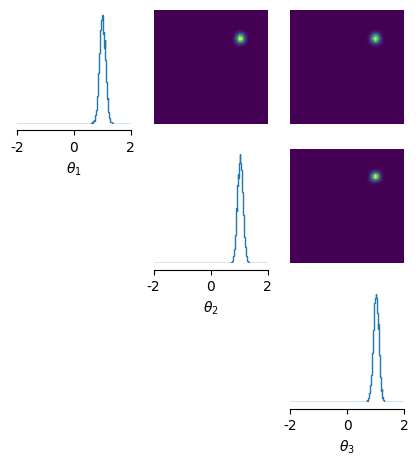

In [14]:
_ = pairplot(
    samples,
    limits=[[-2, 2], [-2, 2], [-2, 2]],
    figsize=(5, 5),
    labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"]
)

### Example 2: Gaussian

Let $\theta = (\mu, \sigma^2)$ denote the parameters of a Gaussian. Our simulator is

$$\text{simulator}(\theta) \sim N(\mu, \sigma^2)$$

We place a uniform prior over $\theta$

$$\theta \sim \text{Unif}[0,3]^2$$

In [111]:
# Define the likelihood (simulator)
num_dim = 2
def simulator(theta):
    return torch.normal(theta[:,0], theta[:,1])

In [112]:
prior = BoxUniform(low=0 * torch.ones(num_dim), high=3 * torch.ones(num_dim))

In [113]:
inference = NPE(prior=prior)
num_simulations = 2000
theta = prior.sample((num_simulations,))
x = simulator(theta).reshape(-1,1)
inference = inference.append_simulations(theta, x)
density_estimator = inference.train()
posterior = inference.build_posterior()

 Neural network successfully converged after 149 epochs.

In [117]:
x_obs = torch.tensor(2.9)
samples = posterior.sample((10000,), x=x_obs)

  0%|          | 0/10000 [00:00<?, ?it/s]

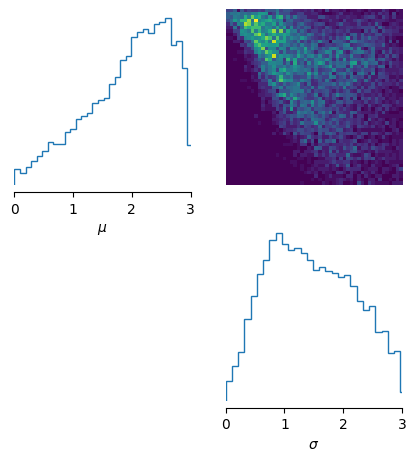

In [119]:
_ = pairplot(
    samples,
    limits=[[0,3], [0,3]],
    figsize=(5, 5),
    labels=[r"$\mu$", r"$\sigma$"]
)

### Example 3: Same as Example 2 but multiple i.i.d samples.

Let $\theta = (\mu, \sigma^2)$ denote the parameters of a Gaussian. Our simulator is

$$\text{simulator}(\theta) = (w_1,...,w_N)$$

where each $w_i \sim N(\mu, \sigma^2)$. We place a uniform prior over $\theta$

$$\theta \sim \text{Unif}[0,3]^2$$

In [132]:
# Define the likelihood (simulator)
num_samples = 50
num_dim = 2
def simulator(theta):
    return torch.normal(theta[:,0].unsqueeze(1).expand(-1, num_samples), theta[:,1].unsqueeze(1).expand(-1, num_samples))

In [133]:
prior = BoxUniform(low=0 * torch.ones(num_dim), high=3 * torch.ones(num_dim))

In [134]:
inference = NPE(prior=prior)
num_simulations = 2000
theta = prior.sample((num_simulations,)) # (num_simulations, 2)
x = simulator(theta).reshape(-1,num_samples) # (num_simulations, n_samples)
inference = inference.append_simulations(theta, x)
density_estimator = inference.train()
posterior = inference.build_posterior()

 Neural network successfully converged after 44 epochs.

In [147]:
x_obs = 2.9 * torch.ones(num_samples) + 0.5 * torch.randn_like(torch.ones(num_samples))
samples = posterior.sample((10000,), x=x_obs)

  0%|          | 0/10000 [00:00<?, ?it/s]

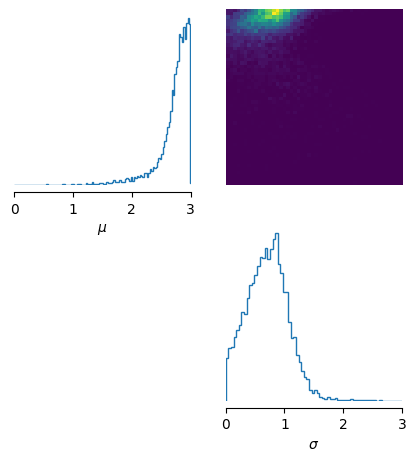

In [148]:
_ = pairplot(
    samples,
    limits=[[0, 3], [0, 3]],
    figsize=(5, 5),
    labels=[r"$\mu$", r"$\sigma$"]
)